In [60]:
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes import convert_to
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.annotation.ggs import GreedyGaussianSegmentation
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import os

%run "1.03-vr-data-loading.ipynb" # makes the load_datasets function available


In [61]:
datasets_by_patient = load_datasets()
datasets_by_patient = create_segmentation_labels(datasets_by_patient)
datasets_by_patient = preprocess_datasets(datasets_by_patient)



In [62]:
from typing import Dict, Optional, List, Tuple, Any
import datetime

def greedy_gaussian_segmentation(
        dataframesByPatient: Dict[str, List[pd.DataFrame]], 
        supervised: bool = False, 
        label_column: Optional[str] = None, 
        k_max: int = 10, 
        time_column: str = 'day_4am'
        ) -> Tuple[GreedyGaussianSegmentation, Dict[str, Dict[str, Any]]]:
    """
    Perform greedy Gaussian segmentation on all datasets simultaneously.
    """
    all_data = []
    all_labels = []
    label_offset = 0

    for patient_id, dataframes in dataframesByPatient.items():
        for df in dataframes:
            # Prepare X
            X = df.drop(columns=[col for col in df.columns if 'msg_type' in col or 'patient_id' in col or col == label_column or col == time_column])
            all_data.append(X)

            # Prepare y if supervised
            if supervised and label_column:
                y = df[label_column] + label_offset
                all_labels.append(y)
                label_offset = y.max() + 1  # Ensure unique labels across datasets

    # Concatenate all data
    X_all = pd.concat(all_data, axis=0)
    
    # Initialize and fit the segmentation model
    segmenter = GreedyGaussianSegmentation(k_max=k_max, verbose=True)
    
    # Fit the model
    print("Beginning to fit the GGS Model...")
    if supervised and label_column:
        y_all = pd.concat(all_labels, axis=0)
        segmenter.fit(X_all, y_all)
    else:
        segmenter.fit(X_all)

    # Perform inference on a random day for each dataset
    results = {}
    for patient_id, dataframes in dataframesByPatient.items():
        results[patient_id] = {}
        for i, df in enumerate(dataframes):
            # Select a random day
            unique_days = pd.to_datetime(df[time_column]).dt.date.unique()
            random_day = np.random.choice(unique_days)
            
            # Filter data for the random day
            day_data = df[pd.to_datetime(df[time_column]).dt.date == random_day]
            
            # Prepare X for prediction
            X_day = day_data.drop(columns=[col for col in day_data.columns if 'msg_type' in col or 'patient_id' in col or col == label_column or col == time_column])
            
            # Predict segmentation
            segmentation = segmenter.predict(X_day)
            
            results[patient_id][f'dataset_{i}'] = {
                'day': random_day,
                'data': day_data,
                'X': X_day,
                'segmentation': segmentation
            }

    return segmenter, results


In [63]:
def visualize_segmentation(
    X_nested: pd.DataFrame, 
    segmentation: np.ndarray, 
    actual_labels: Optional[np.ndarray] = None, 
    column_name: str = 'bgl'
) -> None:
    """
    Visualize the segmented time series data.
    
    Parameters:
    X_nested (pd.DataFrame): The time series data.
    segmentation (np.ndarray): Array of shape (n_samples,) where each entry indicates the segment number.
    actual_labels (Optional[np.ndarray]): Array of actual labels, if available.
    column_name (str): The name of the column to plot.
    
    Returns:
    None: This function plots the visualization but does not return any value.
    """
    plt.figure(figsize=(15, 8))
    
    # Plot the time series
    plt.plot(X_nested.index, X_nested[column_name].values, label=column_name)
    
    # Plot predicted segmentation
    unique_segments = np.unique(segmentation)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))
    
    for segment, color in zip(unique_segments, colors):
        mask = segmentation == segment
        plt.axvspan(X_nested.index[mask].min(), X_nested.index[mask].max(), 
                    alpha=0.2, color=color, label=f'Predicted Segment {segment}')
    
    # Plot actual labels if provided
    if actual_labels is not None:
        unique_labels = np.unique(actual_labels)
        label_colors = plt.cm.Set2(np.linspace(0, 1, len(unique_labels)))
        
        for label, color in zip(unique_labels, label_colors):
            mask = actual_labels == label
            plt.axvspan(X_nested.index[mask].min(), X_nested.index[mask].max(), 
                        alpha=0.2, color=color, hatch='///', label=f'Actual Label {label}')
    
    plt.title(f'{column_name} Over Time with Segmentation')
    plt.xlabel('Time')
    plt.ylabel(column_name)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Version 2: Supervised
This version is supervised. That is, it is trained to segment the data in a particular way.
The meal annotation plus 2 hours dataset is used. The standard GGS algorithm is applied to the entire dataset (individually to each patient's data)
The goal of this model is to segment the data around meal times.


In [64]:
segmenter, results = greedy_gaussian_segmentation(datasets_by_patient, supervised=True, label_column='segmentation_label', k_max=30)

# Visualize results for each patient and dataset
for patient_id, patient_results in results.items():
    for dataset_key, dataset_result in patient_results.items():
        print(f"Visualizing results for Patient {patient_id}, {dataset_key}")
        X_day = dataset_result['X']
        segmentation = dataset_result['segmentation']
        actual_labels = dataset_result['data']['segmentation_label']
        
        visualize_segmentation(X_day, segmentation, actual_labels, column_name='bgl')

Beginning to fit the GGS Model...


ValueError: The (time) index of input must be sorted monotonically increasing, but found: DatetimeIndex(['2024-07-01 05:00:00+00:00', '2024-07-01 05:05:00+00:00',
               '2024-07-01 05:10:00+00:00', '2024-07-01 05:15:00+00:00',
               '2024-07-01 05:20:00+00:00', '2024-07-01 05:25:00+00:00',
               '2024-07-01 05:30:00+00:00', '2024-07-01 05:35:00+00:00',
               '2024-07-01 05:40:00+00:00', '2024-07-01 05:45:00+00:00',
               ...
               '2024-10-01 03:10:00+00:00', '2024-10-01 03:15:00+00:00',
               '2024-10-01 03:20:00+00:00', '2024-10-01 03:25:00+00:00',
               '2024-10-01 03:30:00+00:00', '2024-10-01 03:35:00+00:00',
               '2024-10-01 03:40:00+00:00', '2024-10-01 03:45:00+00:00',
               '2024-10-01 03:50:00+00:00', '2024-10-01 03:55:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=317952, freq=None)

### Visualize supervised results
Plots the results. 
1. The first graph shows what the model predicted for its segments
2. The second graph shows the actual segments in the data

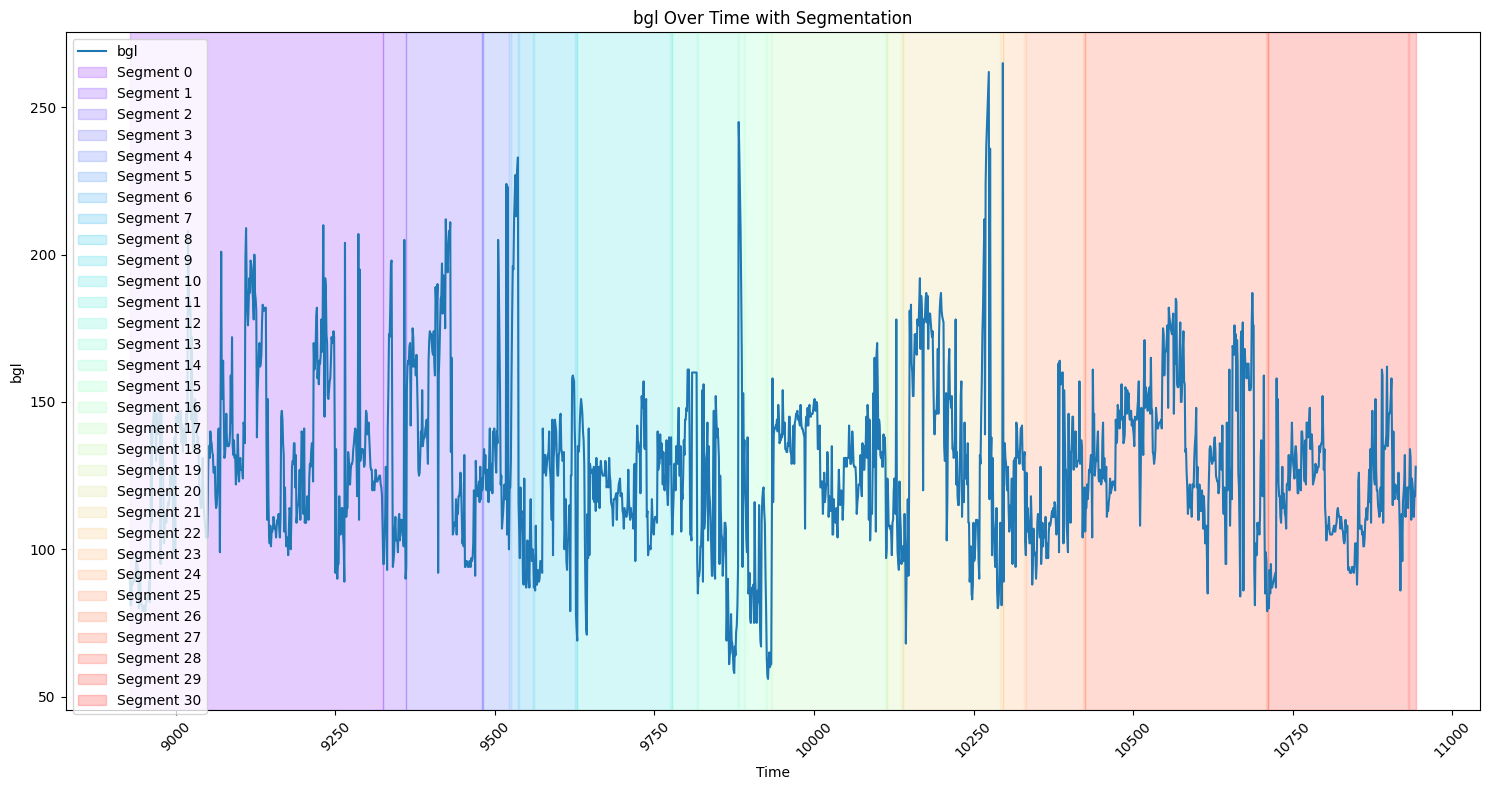

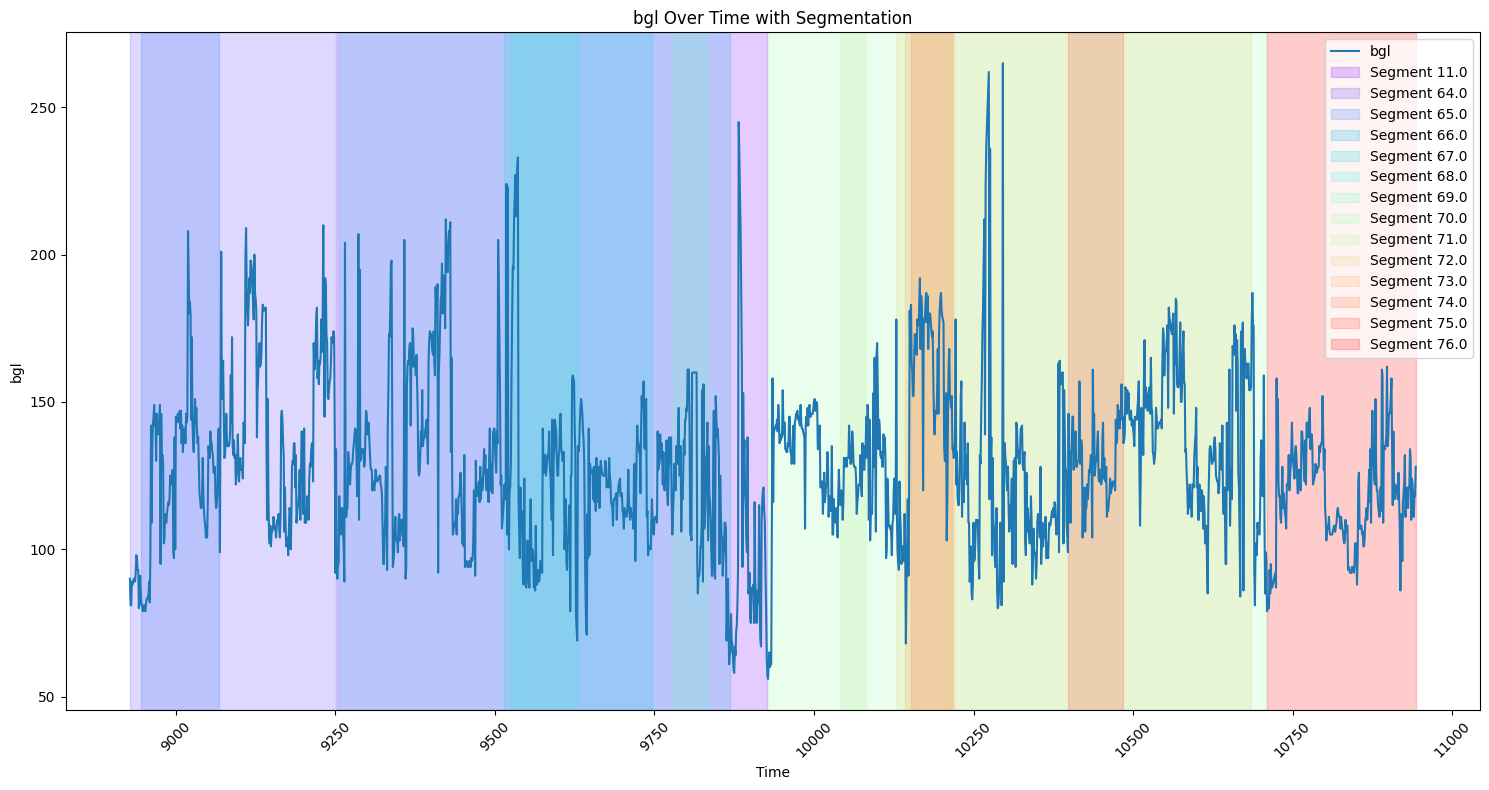

In [56]:
# Visualize the results
# Supervised GGS segmentation
visualize_segmentation(X_nested[['bgl']], supervised_segmentation, column_name='bgl')

# Labelled segmentation from the data
# Filter the meal_segment data based on the timeframe used for X_nested
start_date = X_nested.index[0]
end_date = X_nested.index[-1]
filtered_meal_segment = df.loc[start_date:end_date, 'meal_segment']

# Visualize the filtered meal segments
visualize_segmentation(X_nested[['bgl']], filtered_meal_segment, column_name='bgl')
